<div style="text-align: right"><b>Autor</b>: Jose Miguel Zamora Batista | <b>Fecha</b>: 17 de abril de 2021 </div>

---

# Codelab I: Filtro de Partículas

In [1]:
import time
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image, display, HTML
from dataclasses import dataclass, field

In [2]:
font, font_scale, thickness = cv.FONT_HERSHEY_SIMPLEX, 0.25, 1 

min_h, max_h = 0, 179
min_s, max_s = 104, 255
min_v, max_v = 156, 255


def process_frame(frame):
    frame_hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    
    mask = cv.inRange(frame_hsv, (min_h, min_s, min_v), (max_h, max_s, max_v))
    mask = cv.dilate(mask, (3, 3), iterations=3)
    mask = cv.erode(mask, (3, 3), iterations=3)
    
    contours, _ = cv.findContours(mask, cv.RETR_TREE, 
                                 cv.CHAIN_APPROX_SIMPLE)
    
    rect = cv.boundingRect(contours[0]) if len(contours) > 0 else None
    
    return mask, rect

In [3]:
sequence_path = 'sequences/seq_particles_filter/SecuenciaPelota/%1d.jpg'

In [4]:
@dataclass(repr=True, order=True)
class Particle:
    
    i = 0
    
    name: str = field(init=False, compare=False)
    X: np.array = field(init=True, compare=False)
    w: np.array = field(init=True, compare=True)
    
    def __post_init__(self,):
        self.name = f'P{self.i}'
        self.update()
    
    def copy(self):
        return Particle(self.X, self.w)
    
    def __sub__(self, p) -> np.array:
        return self.X - p.X
    
    def apply_motion(self, v):
        self.X[:2] += v[:2]
    
    def draw(self, canvas, color=(0, 0, 255), thickness=2):
        x, y, w, h = self.X
        cv.rectangle(canvas, (x, y), (x + w, y + h), 
                     color, thickness, cv.LINE_AA)
        cv.putText(canvas, self.name, (x, y - 5), font, font_scale, 
                   color, 1, cv.LINE_AA, False)
    
    @classmethod
    def update(cls): cls.i += 1
    
    @classmethod
    def restart(cls): cls.i = 0
    
    @staticmethod
    def spawn_random(max_x, max_y, p_w, p_h, weight):
        X = [np.random.randint(0, max_x), 
             np.random.randint(0, max_y), p_w, p_h]
        return Particle(np.array(X), weight)

In [5]:
class ParticlesFilter:
    
    def __init__(self, N, world_shape, particles_size, sigma):
        self.N = N
        self.w, self.h = world_shape
        self.pw, self.ph = particles_size
        
        self.estimations = []
        self.sigma = sigma
        self.v = np.zeros((2,))
        
    def initiation(self, ):
        self.particles = [Particle.spawn_random(
            self.w, self.h, self.pw, self.ph, 1/self.N
        ) for _ in range(self.N)]
    
    def draw(self, frame, color=(255, 255, 0), 
             estimation_color=(255, 0, 255), text=''):
        
        for particle in self.particles:
            particle.draw(frame, color, thickness=1)
            
        cv.putText(frame, text, (10, 10), font, font_scale, 
                   color, thickness, cv.LINE_AA, False)
        
        for particle in self.estimations[-1:]:
            particle.draw(frame, estimation_color, thickness=2)
        
    def evaluation(self, frame):        
        weights = np.zeros((self.N, )) 
        W = np.sum(frame) 
        
        for i, particle in enumerate(self.particles):
            x, y, w, h = particle.X
            window = frame[y:y+h, x:x+w]   
        
            weight = np.sum(window) / (W + 1e-15)
            weights[i] = weight
    
        weights = weights / (np.sum(weights) + 1e-15 )
        
        for i, particle in enumerate(self.particles):
            particle.w = weights[i]
    
    def estimation(self):
        p: Particle = sorted(self.particles, reverse=True)[0].copy()
        p_last: Particle = self.estimations[-1] if len(self.estimations) > 0 else p
        
        self.estimations.append(p)
        self.v = p - p_last
 
    def selection(self, ):
        new_particles = []
        
        weights = [p.w for p in self.particles]
        cumsum_weights = np.cumsum(weights)
        
        for _ in range(len(weights)):
            csw_greater = cumsum_weights > np.random.uniform()
    
            particle = self.particles[np.argmax(csw_greater)]
            particle.w = 1 / self.N
            new_particles.append(particle)
        
        self.particles = new_particles
            
    def diffusion(self):
        for i in range(self.N):
            p = self.particles[i]
            x, y, w, h = p.X
            
            w_p = self.w * self.sigma
            h_p = self.h * self.sigma
            
            x_noise = np.random.randint(-w_p, w_p)
            y_noise = np.random.randint(-h_p, h_p)
            
            x = max(min(x + x_noise, self.w), 0)
            y = max(min(y + y_noise, self.h), 0)
            
            p.X = np.array([x, y, w, h])
            
            self.particles[i] = p.copy()

    def motion_modeling(self):  
        for p in self.particles:
            p.apply_motion(self.v)

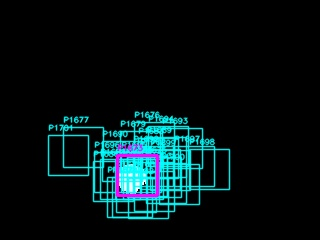

In [6]:
vc = cv.VideoCapture(sequence_path)

fs = int(vc.get(cv.CAP_PROP_FRAME_COUNT))
ww = int(vc.get(cv.CAP_PROP_FRAME_WIDTH))
wh = int(vc.get(cv.CAP_PROP_FRAME_HEIGHT))

ratio = 2
mw, mh = int(ww * ratio), int(wh * ratio)

fps = 10

display_handle = display(None, display_id=True)

w_size = (ww, wh)

# Ajustar la cantidad de partículas
p_amount = 30

# Ajustar el tamaño de la partícula
p_s = 40
p_size = (p_s, p_s)

Particle.restart()
particles_filter = ParticlesFilter(p_amount, w_size, 
                                   p_size, sigma=0.09)

for i in range(fs):
    
    if i == 0:
        particles_filter.initiation()
    
    _, frame = vc.read()
    
    mask, rect = process_frame(frame)
    
    if rect is not None:
        
        mask_aux = mask / 255.
        
        # Evaluation
        particles_filter.evaluation(mask_aux)
        
        # Estimation
        particles_filter.estimation()
        
        # Selection
        particles_filter.selection()
        
        # Diffusion
        particles_filter.diffusion()
        
        # Motion Modeling
        particles_filter.motion_modeling()

    mask_rgb = cv.cvtColor(mask, cv.COLOR_GRAY2BGR)
    
    draw_in = mask_rgb
    
    particles_filter.draw(draw_in)
    display_handle.update(Image(
        data=cv.imencode('.jpeg', draw_in)[1]
    ))    
    time.sleep(1 / fps)
    
vc.release()

---

# Pregunta Teórica

Explica y razona qué perturbación has aplicado en la etapa de difusión y con qué parámetros. ¿Por qué es necesaria esta etapa?

**Respuesta**

La perturbación aplicada en la etapa de difusión consiste en modificar aleatoriamente en un valor de la posición en el estado de la partícula, para todas las partículas.

Este paso es necesario puesto que tras la etapa de *selección* es posible que se seleccionen la misma partícula varias veces, provocando un empobrecimiento de la población de partículas. Es por eso que se pertuba el estado, para tener 
varias partículas a partir de las que fueron seleccionadas.